# 1. Import libraries

In [55]:
# Import necessary libraries
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models
from google.colab import drive
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
# From here, add any libraries that you might need for the rest of your code

# 2. Load and pre-process the dataset

In [34]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# Set the paths based on your Drive directory
data_dir ='/content/drive/MyDrive/Deep_Learning/Assignment/data' # Change to the path to your directory
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: /content/drive/MyDrive/Deep_Learning/Assignment/data
Training directory: /content/drive/MyDrive/Deep_Learning/Assignment/data/Training
Testing directory: /content/drive/MyDrive/Deep_Learning/Assignment/data/Testing


In [36]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) #This option will remount the Google Drive, even if it's already mounted.

Mounted at /content/drive


*   This code loads images from directories, adds noise to them, rescales them, and prepares them for training/testing
*   Training data is shuffled and processed in batches of 32 images.
    *   Shuffle for Training: Helps the model generalize by presenting the data in a different order, reducing the risk of model overfitting or learning the order of the data.
    *   No shuffle for Testing: It keeps the test data in the same order, so the evaluation is consistent and reliable.

*   The images are resized to 30x30 pixels, and their pixel values are normalized between 0 and 1.
*   Classes are one-hot encoded, which is important for multi-class classification problems.





In [37]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# Load and preprocess the data
# add_noise : To add random Gaussian noise to each image, which can help the model generalize better by preventing it from memorizing training data
np.random.seed(seed=42)
def add_noise(img):
    std_coeff = 70*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

image_res = 30 # resized to 30x30 pixels for processing
def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, # Rescales image pixel values from [0,255] to [0,1]
                                 preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    # Load training data
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width), # Resizes every image to 30x30 pixels
        batch_size=batch_size, # Loads 32 images at a time
        class_mode='categorical', # One-hot encoding happens here
        shuffle=True,
        color_mode='grayscale' # they only have one color channel(insted of three for RGB)
    )

    # Load test data
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width), # Resizes every image to 30x30 pixels
        batch_size=batch_size, # Loads 32 images at a time
        class_mode='categorical', # One-hot encoding happens here
        shuffle=False,
        color_mode='grayscale' # they only have one color channel(insted of three for RGB)
    )

    return train_data, test_data

# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# 3. Visualise data and plot data distribution

*   Visualise random 15 samples from the dataset. Image should be displayed with its corresponding label as text on top of the image.





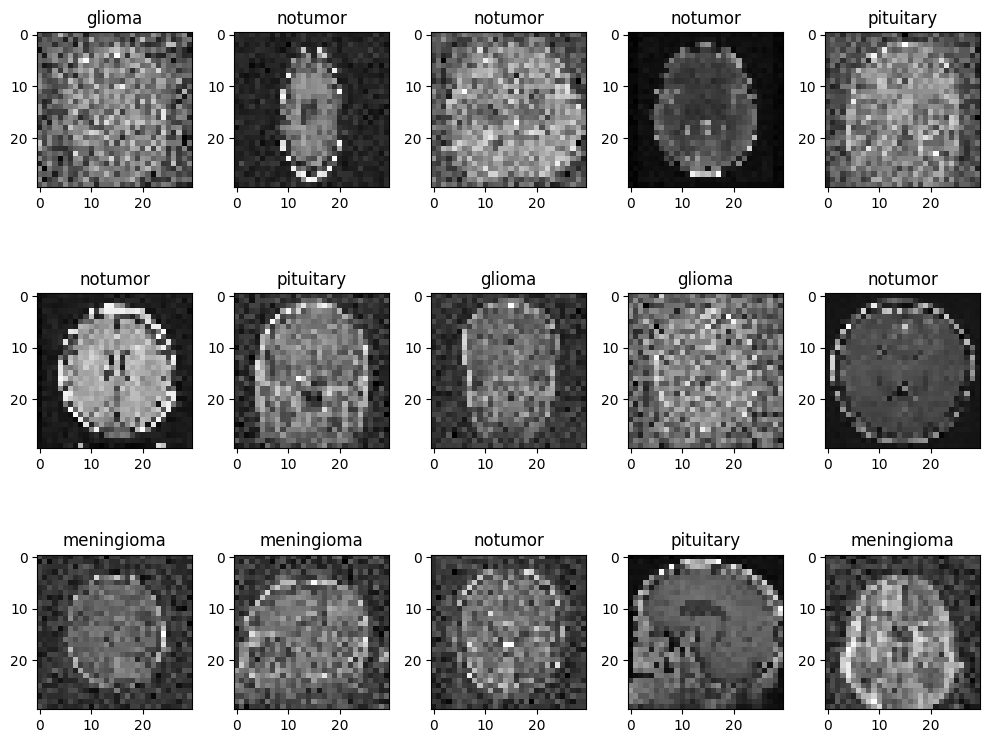

In [38]:
# Function to display 15 random samples from the dataset
def display_random_samples(data_gen, num_samples=15):
    images, labels = next(data_gen)  # Get one batch of images
    indices = random.sample(range(len(images)), num_samples)  # Randomly select 15 images

    plt.figure(figsize=(10, 8))
    for i, idx in enumerate(indices):
        plt.subplot(3, 5, i+1)  # Arrange in a grid 3x5
        img = images[idx].squeeze()  # Squeeze to remove any singleton dimensions (if grayscale)
        plt.imshow(img, cmap='gray')  # Assuming grayscale
        label_idx = np.argmax(labels[idx])  # Get the class label index
        class_label = [k for k, v in train_data.class_indices.items() if v == label_idx][0]
        plt.title(class_label)
    plt.tight_layout()
    plt.show()

# Call the function to display 15 random samples from the training data
display_random_samples(train_data)

*   Create a bar plot to visulaize the class label distribution of the dataset




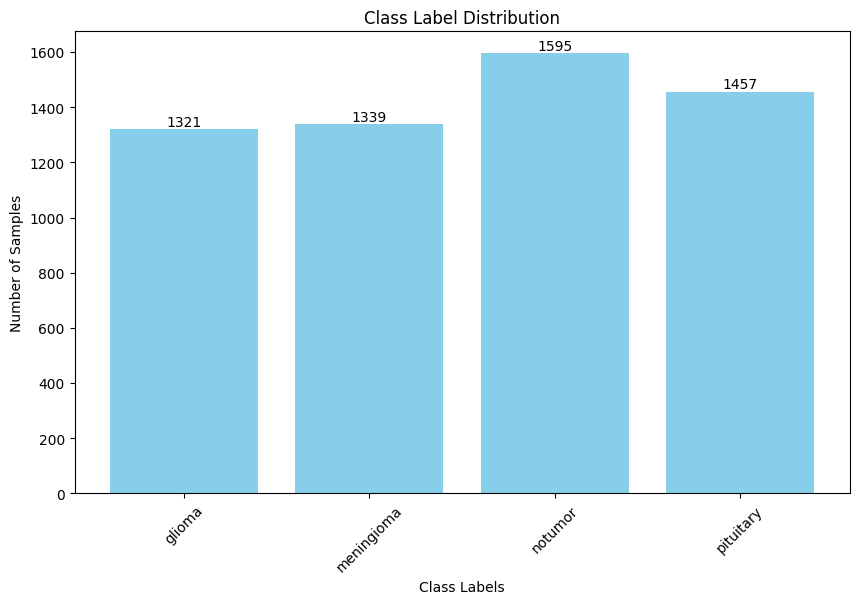

In [39]:
# Create a bar plot to visualize the class label distribution
def plot_class_distribution(data_gen):
    class_labels = list(data_gen.class_indices.keys())  # Get class labels
    num_samples = list(data_gen.classes)  # List of classes for all samples
    class_count = np.bincount(num_samples)  # Count of each class

    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_labels, class_count, color='skyblue')

    plt.xlabel('Class Labels')
    plt.ylabel('Number of Samples')
    plt.title('Class Label Distribution')
    plt.xticks(rotation=45)

    # Add the total number on top of each bar
    for bar, count in zip(bars, class_count):
        yval = bar.get_height()  # Height of the bar (number of samples)
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(count)}', ha='center', va='bottom')

    plt.show()

# Call the function to create the class distribution plot
plot_class_distribution(train_data)


# 4. Train and Evaluation functions

*   Implement the baseline CNN algorithm without any modification for both model and dataset.

  1.   Convolutional layer with 32 filters and kernel size of 3 x 3 with ReLU activations followed by a max pooling layer of size 2 x 2
  2.   Convolutional layer with 32 filters and kernel size of 3 x 3 with ReLu activations followed by a max pooling layer of size 2 x 2
  3.   Flatten the 3D output
  4.   Desn layers of sizes 32 and with Relu activation
  5.   Output layer with softmax activation are added for multi-class classification
  6. The optimizer should be Adam, metric should be acrruracy. The categorical crossentropy loss function is used for multi-class classification problems.







In [44]:
# Correct input shape for grayscale images (30x30 pixels, 1 channel)
img_shape = (30, 30, 1)  # 30x30 pixels, 1 channel (grayscale)
model = models.Sequential()

# first convolutional layer + max pooling layer
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = img_shape))
model.add(layers.MaxPooling2D((2,2)))

# second convolutional layer + max pooling layer
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# flatten the 3D output from the convolutional layers into 1D
model.add(layers.Flatten())

# Dense layer with 32 units and ReLU activation
model.add(layers.Dense(32, activation = 'relu'))

num_classes = len(list(train_data.class_indices.keys()))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Loss function for multi-class classification
              metrics=['accuracy'])

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │          36,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,596 (182.02 KB)

 Trainable params: 46,596 (182.02 KB)

 Non-trainable params: 0 (0.00 B)

*   Analyze the performance of the baseline by plotting
  1.   **Split the training data and validation data again due to the restriction of not modifying the preprocessing code.**
  2.   The training and validation losses and accuracies on the training and validation set through epochs
  3.   The Receiver Operator Characteristic (ROC) curve with the Area under the Curve (AUC) score and a confusion matrix for the validation and test sets.
  4.   Report performance measures (accuracy, precision, recall, and F1-score) for both validation and test sets.






In [51]:
def get_images(train_dir: str, test_dir: str):
    # ImageDataGenerator with validation split
    datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=add_noise,
        validation_split=0.2  # Use 20% for validation
    )

    img_height, img_width = image_res, image_res
    batch_size = 32

    # Training data (80%)
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        color_mode='grayscale',
        subset='training'  # Use 80% for training
    )

    # Validation data (20%)
    val_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        color_mode='grayscale',
        subset='validation'  # Use 20% for validation
    )

    # Test data
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        color_mode='grayscale'
    )

    return train_data, val_data, test_data  # Return all 3 datasets

# Load training, validation, and test data
train_data, val_data, test_data = get_images(train_images_dir, test_images_dir)

# Train the model with validation data
history = model.fit(
    train_data,  # Training data
    validation_data=val_data,  # Validation data
    epochs=10
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 49s 317ms/step - accuracy: 0.4413 - loss: 1.1845 - val_accuracy: 0.6617 - val_loss: 0.9294
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 51s 345ms/step - accuracy: 0.7245 - loss: 0.7302 - val_accuracy: 0.6845 - val_loss: 0.8788
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 316ms/step - accuracy: 0.7603 - loss: 0.6519 - val_accuracy: 0.6275 - val_loss: 0.9822
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 96s 415ms/step - accuracy: 0.7698 - loss: 0.6107 - val_accuracy: 0.6678 - val_loss: 0.9479
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 386ms/step - accuracy: 0.7928 - loss: 0.5331 - val_accuracy: 0.6897 - val_loss: 0.8603
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 311ms/step - accuracy: 0.8074 - loss: 0.5049 - val_accuracy: 0.6880 - val_loss: 0.8658
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 51s 347ms/step - accuracy: 0.8043 - loss: 0.4931 - val_accuracy: 0.6424 - val_loss: 0.9419
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 318ms/step - accuracy: 0.8249 - loss: 0.4815 - val

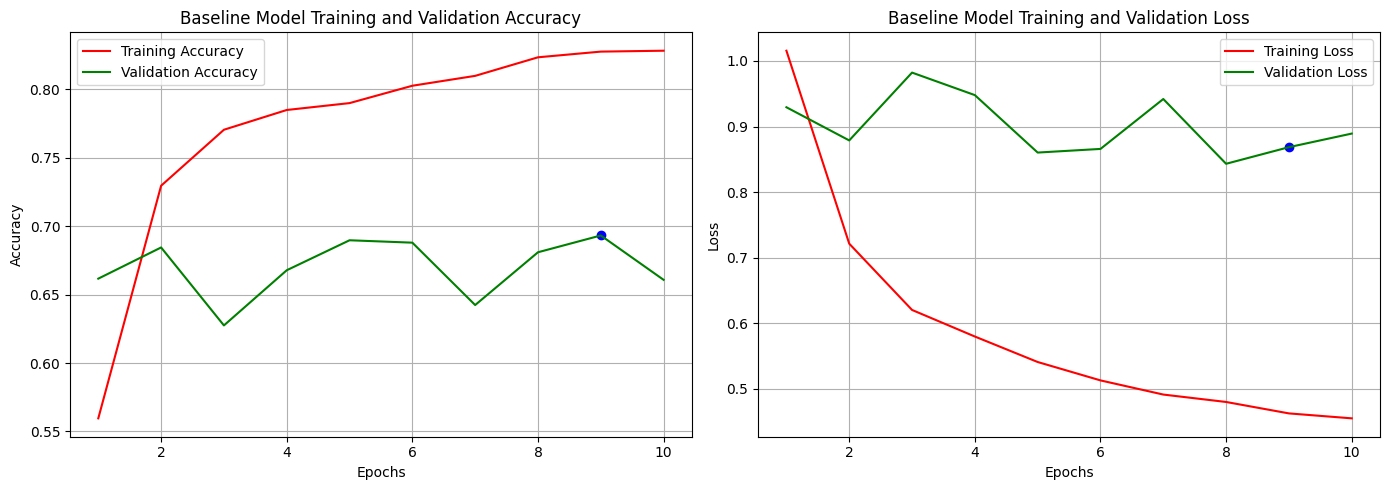

In [54]:
# Assuming 'history' is the variable that holds the result of model.fit()
def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'r', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'g', label='Validation Accuracy')
    plt.title('Baseline Model Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Highlight the best epoch for validation accuracy
    best_epoch_acc = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
    plt.scatter(best_epoch_acc, max(history.history['val_accuracy']), label=f'Best epoch = {best_epoch_acc}', color='blue')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'r', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'g', label='Validation Loss')
    plt.title('Baseline Model Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Highlight the best epoch for validation loss based on the best validation accuracy epoch
    plt.scatter(best_epoch_acc, history.history['val_loss'][best_epoch_acc - 1], label=f'Best epoch = {best_epoch_acc}', color='blue')

    plt.tight_layout()
    plt.show()

# Call the function with the history object returned from model.fit()
plot_training_history(history)


# 5. Model training

# 6. Model evaluation